## How to calculate the disconnected (= Gaussian) power spectrum covariance

Reference: [Yin Li+18](https://arxiv.org/abs/1811.05714).

In [1]:
from jax import numpy as jnp
from jaxpower import MeshAttrs, Spectrum2Poles, BinMesh2Spectrum, compute_spectrum2_covariance

def get_theory(kmax=0.3, dk=0.005):
    # Return theory power spectrum
    from cosmoprimo.fiducial import DESI
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    ellsin = (0, 2, 4)
    edgesin = jnp.arange(0., kmax, dk)
    edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
    kin = (edgesin[..., 0] + edgesin[..., 1]) / 2.
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    shotnoise = (1e-3)**(-1)
    pk = pk1d(kin)
    poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk + shotnoise,
                        (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,
                        8. / 35 * beta ** 2 * pk])
    return Spectrum2Poles(k=[kin] * len(ellsin), edges=[edgesin] * len(ellsin), num=list(poles), num_shotnoise=shotnoise, ells=ellsin)

# Mesh used to estimate P(k) --- for binning effects
attrs = MeshAttrs(boxsize=1000., meshsize=128)
# Underlying P(k) theory
theory = get_theory(kmax=attrs.knyq.max(), dk=0.001)
# *Including* shot noise in the covariance matrix
theory = theory.clone(num_shotnoise=0.)

# Here computing the discrete modes on the grid
bin = BinMesh2Spectrum(attrs, edges=theory.edges(projs=0))
theory = theory.clone(nmodes=bin.nmodes)

# Covariance matrix with same binning as input theory (dk = 0.001)
covmat = compute_spectrum2_covariance(attrs, theory, flags=[])
# Then rebin to your actual binning (e.g. dk = 0.005)
covmat = covmat.slice(slice(0, None, 5))

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/local/home/adematti/software/desi/cosmodesiconda/20250205-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1338: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


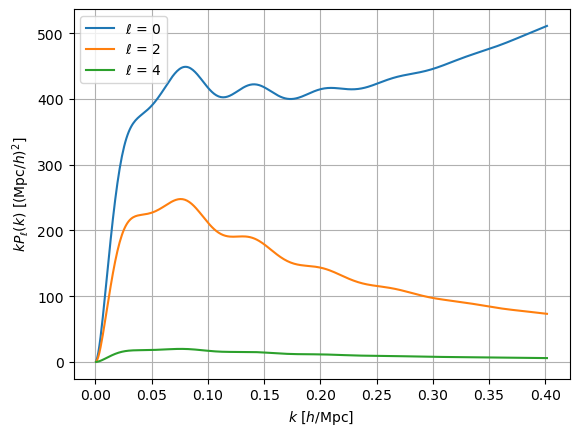

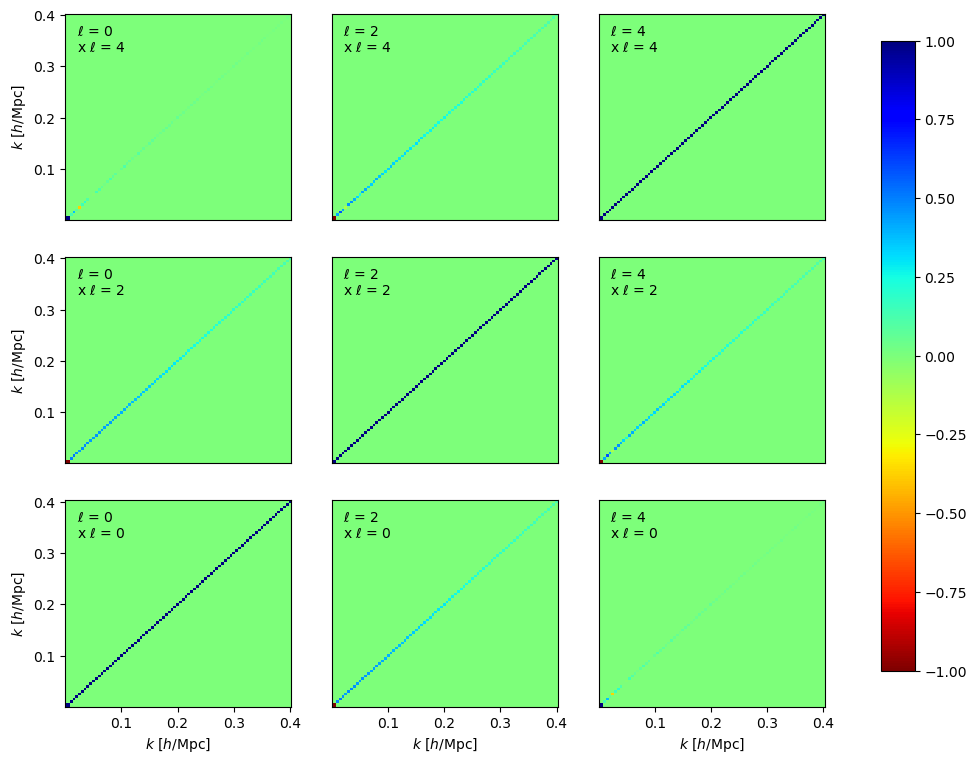

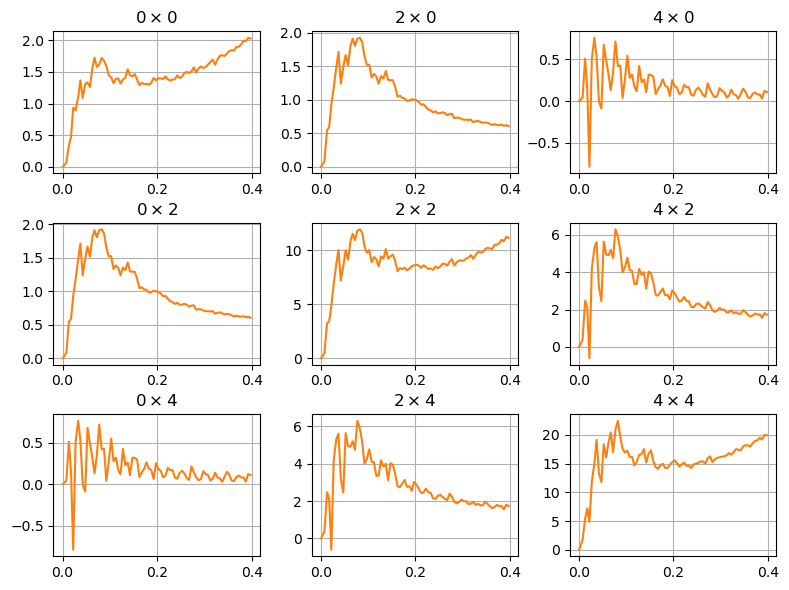

In [2]:
# Plot input theory power spectrum (including shot noise)
theory.plot(show=True)
# Plot covariance matrix
covmat.plot(corrcoef=True, show=True)
# Plot diagonals of the different blocks
covmat.plot_diag(ytransform = lambda x, y: x**4 * y, color='C1', show=True);

In [3]:
# To select the covariance matrix, e.g. 0 < k < 0.3 and ells = (0, 2)
submat = covmat.select(xlim=(0., 0.3), projs=[0, 2], select_projs=True)
# To access the covariance matrix as an array
array = submat.view()

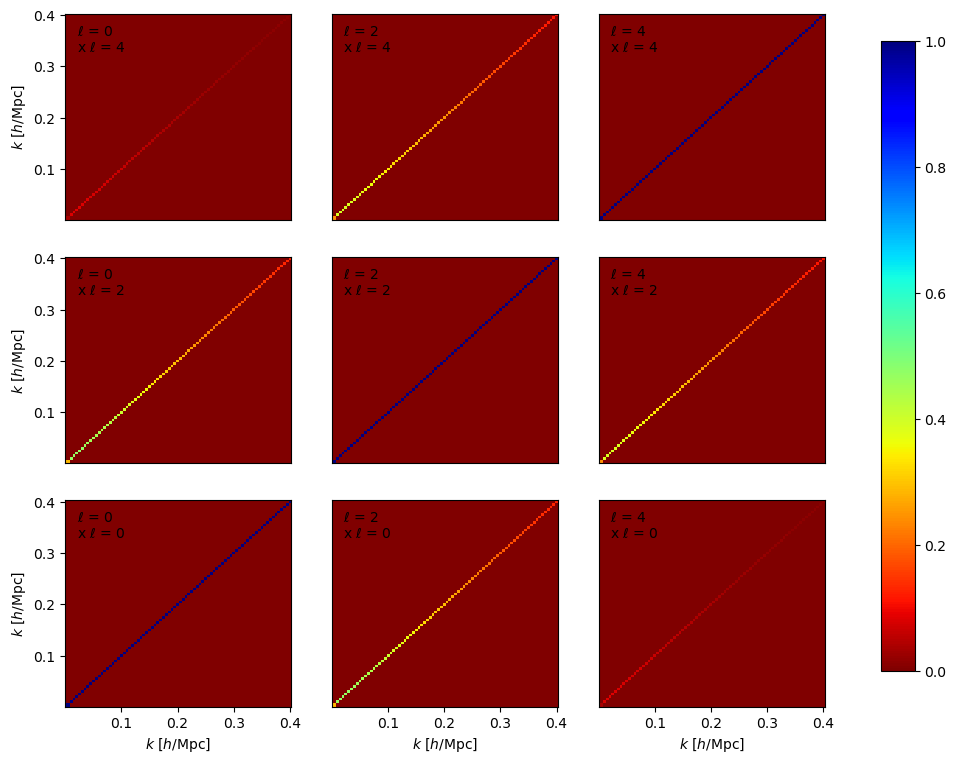

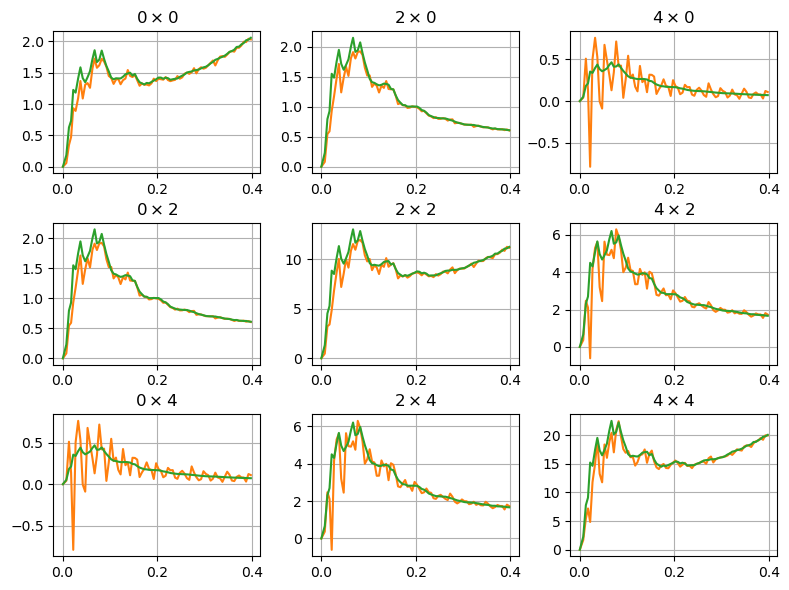

In [4]:
# Oscillations are due to mesh resolution effects, here is the version without mesh resolution

# Covariance matrix with same binning as input theory (dk = 0.001)
covmat_smooth = compute_spectrum2_covariance(attrs, theory, flags=['smooth'])
# Then rebin to your actual binning (e.g. dk = 0.005)
covmat_smooth = covmat_smooth.slice(slice(0, None, 5))

# Plot covariance matrix
covmat_smooth.plot(corrcoef=True, show=True)
# Plot diagonals of the different blocks
fig = covmat.plot_diag(ytransform = lambda x, y: x**4 * y, color='C1');
covmat_smooth.plot_diag(ytransform = lambda x, y: x**4 * y, color='C2', fig=fig, show=True);